<h1 style="text-align: center; font-size: 36px;">Recurrent Neural Networks (RNNs)</h1>

##### Student information:
- Name: Tuan Anh NGUYEN
- Email: tuan.nguyen@etu.univ-cotedazur.fr

---

##### Tasks:

1. Build a parameterizable RNN for time series forecasting
    - The length of the time series must not be known when the network is built
    - The number of input features is known (n_in)
    - The offset (off) is known
    - The number of features to be predicted is known (n_out==1)
    - Input shape of the network: (None, None, n_in)
    - Output shape of the network: (None, 1, n_out) or (None, n_out)
2. Fit and use the model for forecasting
    - M1: Use 24 months in the past to predict the next month
    - M2 : Use 12 months in the past to predict the next month
    - M3 : Use 12 months in the past to predict the first month of the next trimester (offset = 4)
    - Use MeanSquaredLogarithmicError to evaluate the network

---





First, we need import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input

TensorFlow and Keras version

In [2]:
# Print the tensorflow and keras version
print("TensorFlow version", tf.__version__)
print("Keras version", tf.keras.__version__)

TensorFlow version 2.17.0
Keras version 3.6.0


##### 1. Build a parameterizable RNN for time series forecasting

In [3]:
def load_data():
    # Load the data from the .csv file
    rainfall_data_df = pd.read_csv('precipitation.csv', sep="\t", engine="python", on_bad_lines="skip")
    rainfall_data_df.set_index('Year', inplace=True)            # Replace the index column with the Year column

    # Flatten the data
    data = rainfall_data_df.to_numpy().ravel()
    
    # Plot the dataset
    plt.figure(figsize=(13,4))
    plt.boxplot(rainfall_data_df)
    plt.xlabel('Month')
    plt.ylabel('Precipitation(mm)')
    plt.title('Month vs Precipitation across all years')
    
    return data

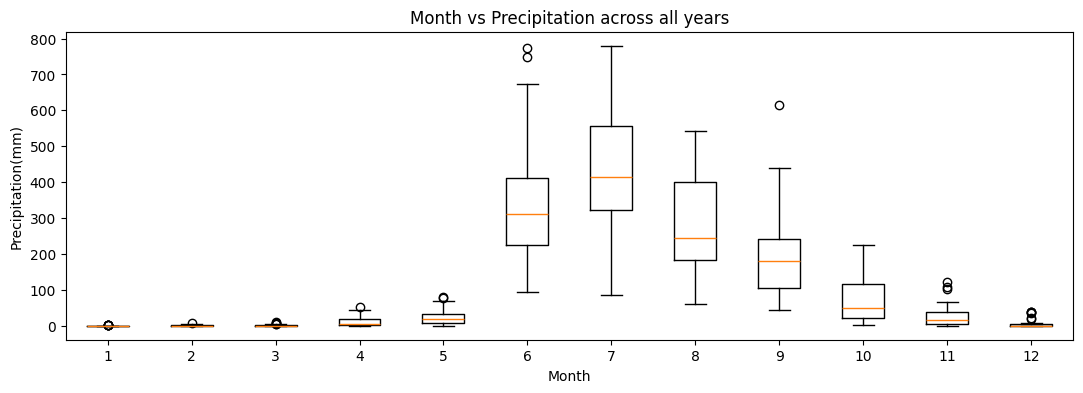

In [4]:
data = load_data()

Now, I will split the data into training set and test set, with training set: $70\%$, validation set: $20\%$ and test set: $10\%$. I will take the first $70\%$ of data to be trained, $20\%$ of data to be validated and the remain $10\%$ of data to be tested.

In [5]:
def split_data():
    train_data = data[:int(0.7*len(data))]
    val_data = data[int(0.7*len(data)):int(0.9*len(data))]
    test_data = data[int(0.9*len(data)):]
    
    return train_data, val_data, test_data

Now, we need to normalize the dataset: ***train_data, val_data, test_data***. In this approach, I fit the training data and apply the rule of transformation for each of them

In [6]:
def normalize_data():
    train_data, val_data, test_data = split_data()
    
    transformer = RobustScaler().fit(train_data.reshape(-1,1))
    train_data = transformer.transform(train_data.reshape(-1,1))
    
    test_data = transformer.transform(test_data.reshape(-1,1))
    
    val_data = transformer.transform(val_data.reshape(-1,1))
    
    return train_data, val_data, test_data, transformer

In [7]:
train_data, val_data, test_data, transformer = normalize_data()

Create the dataset for model, it takes 2 arguments which are: *input_width* (The width of the input dataset) and *offset* (The offset length of the output) with its value between $1$ and $4$.


In [8]:
def dataBuilder(input_width = 0, offset = 1):
    
    X_train = [train_data[i : i + input_width] for i in range(len(train_data) - input_width - offset + 1)]
    X_train = np.array(X_train)
    y_train = [train_data[i + input_width + offset - 1] for i in range(len(train_data) - input_width - offset + 1)]
    y_train = np.array(y_train)
    
    X_test = [test_data[i : i + input_width] for i in range(len(test_data) - input_width - offset + 1)]
    X_test = np.array(X_test)
    y_test = [test_data[i + input_width + offset - 1] for i in range(len(test_data) - input_width - offset + 1)]
    y_test = np.array(y_test)
    
    X_val = [val_data[i : i + input_width] for i in range(len(val_data) - input_width - offset + 1)]
    X_val = np.array(X_val)
    y_val = [val_data[i + input_width + offset - 1] for i in range(len(val_data) - input_width - offset + 1)]
    y_val = np.array(y_val)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Now, we build the RNN model. It will take 1 argument is number of feature: *n_feature* and return the corresponding *model*

In [9]:

def my_RNN(n_feature = 1):
    
   # Build the model
    model = Sequential([
        Input(shape=(None, n_feature)),
        LSTM(50, return_sequences=False),  # Single LSTM layer
        Dense(units=1, activation='relu')   # Dense with 1 unit and activation is 'relu
    ])

    # Compile the model with Mean Squared Logarithmic Error
    model.compile(loss='msle', optimizer='adam')
    
    return model

This function will be used to plot the data

In [10]:
def plot_data(y_test, y_pred, model_name):
    plt.figure(figsize=(12, 6))

    # Plot the real data
    plt.plot(y_test, label='Real Data', color='blue')

    # Plot the forecast data
    plt.plot(y_pred, label='Forecast Data', color='red', linestyle='dotted')

    plt.xlabel('Data')
    plt.ylabel('Value')
    plt.title(f'Real vs Forecast Data of {model_name}')
    plt.legend()
    plt.show()

##### 2. Fit and use the model for forecasting

First, I will build the generic model to be used. It will take 3 arguments: ***input_width, offset*** and ***model_name***

In [11]:
def evaluate_model(input_width = 0, offset = 1, model_name=''): 
    # Get the dataset
    X_train, y_train, X_val, y_val, X_test, y_test = dataBuilder(input_width, offset)
    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')
    
    # Get the RNN model
    lstm_model = my_RNN()
    
    # Fit with the training data and validation data
    history = lstm_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    # Evaluate the model
    y_pred = lstm_model.predict(X_test)
    e_val = lstm_model.evaluate(X_test, y_test, verbose=0, return_dict=True)
    print('Evaluating', e_val)
    
    # Inverse the tranformation of the test data and prediction data
    y_pred_origin = transformer.inverse_transform(y_pred.reshape(len(y_pred),-1))
    y_test_origin = transformer.inverse_transform(y_test.reshape(len(y_test),-1))
    plot_data(y_test=y_test_origin, y_pred=y_pred_origin, model_name = model_name)
    

- M1: Use 24 months in the past to predict the next month

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.3031 - val_loss: 0.2550
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2125 - val_loss: 0.2309
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2221 - val_loss: 0.2013
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1493 - val_loss: 0.1722
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1520 - val_loss: 0.1485
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1322 - val_loss: 0.1310
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1249 - val_loss: 0.1149
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1109 - val_loss: 0.1024
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0890 - val_loss: 0.0852
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0702 - val_loss: 0.0820
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0555 - val_loss: 0.0802
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0714 - val_l

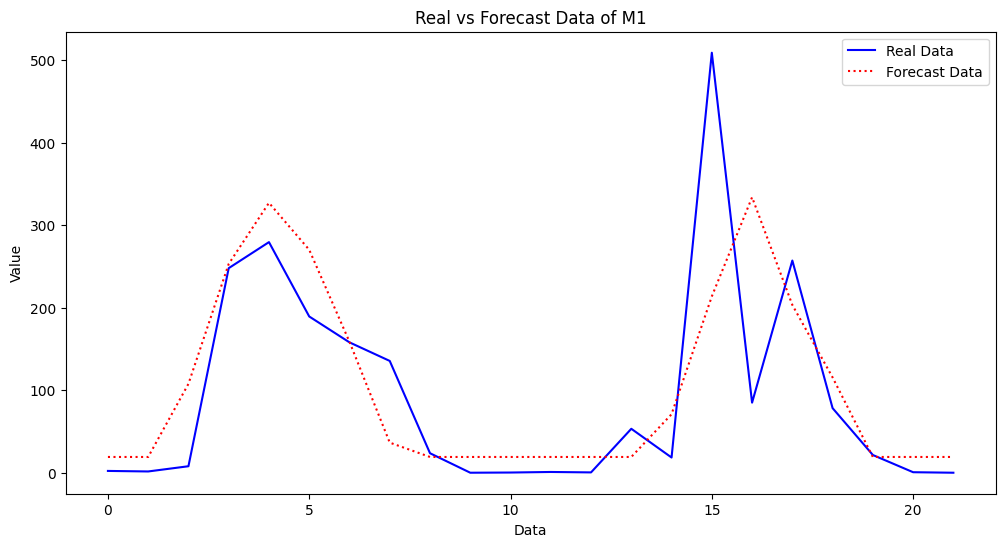

In [12]:
evaluate_model(input_width = 24, offset=1, model_name='M1')

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2607 - val_loss: 0.2583
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2130 - val_loss: 0.2283
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1825 - val_loss: 0.1941
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1496 - val_loss: 0.1547
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1180 - val_loss: 0.1179
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0887 - val_loss: 0.0827
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0725 - val_loss: 0.0725
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0663 - val_loss: 0.0821
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0791 - val_loss: 0.0829
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0676 - val_loss: 0.0700
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0669 - val_loss: 0.0672
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0648 - val_l

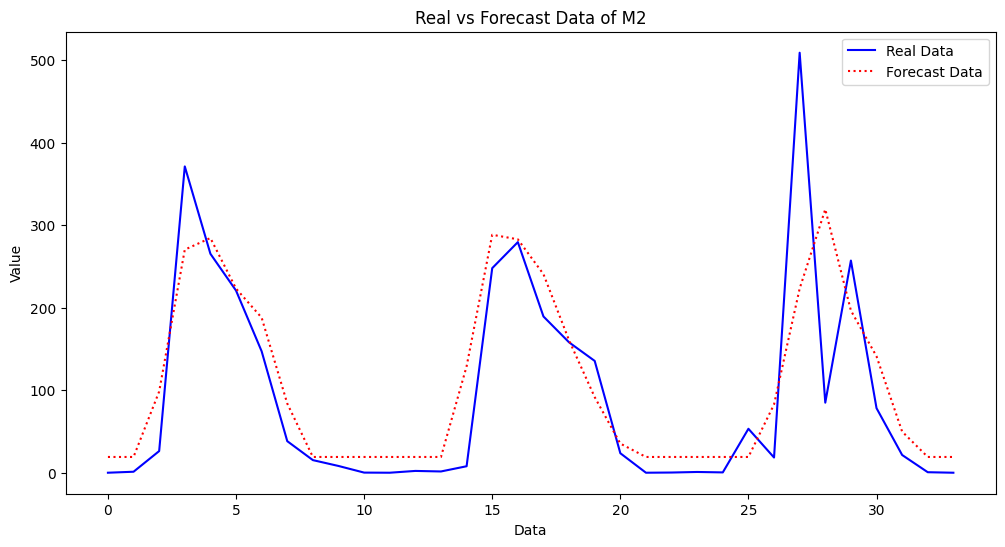

In [13]:
evaluate_model(input_width = 12, offset=1, model_name='M2')

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.2938 - val_loss: 0.2401
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1922 - val_loss: 0.1862
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1506 - val_loss: 0.1448
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1259 - val_loss: 0.1221
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1072 - val_loss: 0.1157
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0983 - val_loss: 0.1110
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0932 - val_loss: 0.1091
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0939 - val_loss: 0.1064
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0987 - val_loss: 0.1023
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0814 - val_loss: 0.0980
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0821 - val_loss: 0.0937
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0799 - val_l

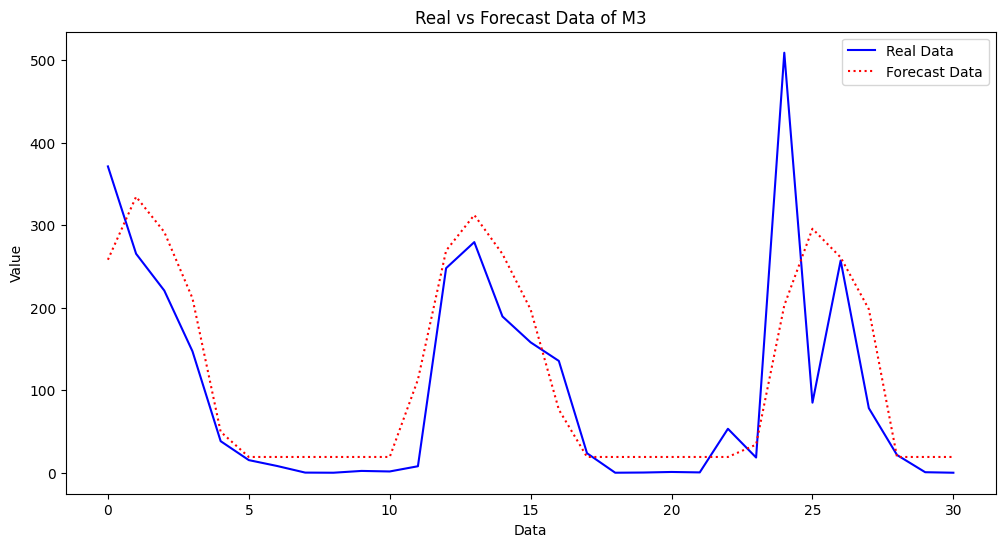

In [14]:
evaluate_model(input_width = 12, offset=4, model_name='M3')

---

##### Conclusion:
- Through this part, I've learned Recurrent Neural Networks (RNNs) and the procedure to build the RNN model.
- I also learned how to prepare the data for training, validation and testing.


References:
- Tensorflow keras documentations: https://www.tensorflow.org/api_docs/python/tf/keras/,
- Time series forecast: https://www.tensorflow.org/tutorials/structured_data/time_series#setup